In [2]:
import pandas as pd

In [36]:
train_df_encoded = pd.read_csv("/kaggle/input/train-df-enc/train_df_encoded (1).csv").set_index("filename")
test_df_encoded = pd.read_csv("/kaggle/input/test-df/test_df_encoded.csv").set_index("filename")
val_df_encoded = pd.read_csv("/kaggle/input/test-df/val_df_encoded.csv").set_index("filename")

In [37]:
train_df_encoded

,baseColour,articleType,season,gender
filename,,,,
42600.jpg,9,21,2,2
56700.jpg,7,12,2,0
57188.jpg,6,13,2,2
3279.jpg,0,23,2,0
29177.jpg,1,17,2,0
...,...,...,...,...
56555.jpg,7,13,1,2
14094.jpg,3,23,0,0
5471.jpg,7,19,2,0


In [39]:
val_df_encoded.head()

,baseColour,articleType,season,gender
filename,,,,
4925.jpg,3,21,2,2
5158.jpg,2,23,2,0
52996.jpg,5,13,0,2
6762.jpg,1,23,2,0
11171.jpg,0,13,0,0


In [ ]:
import pickle 

with open('/kaggle/input/test-df/saved_encoders_dictionary.pkl', 'rb') as f:
    loaded_encoders_dict = pickle.load(f)   

In [7]:
import tensorflow as tf

In [8]:
IMAGES_PATH = '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/'
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64
EPOCHS = 10
AUTOTUNE = tf.data.AUTOTUNE

(2400, 1800, 3)


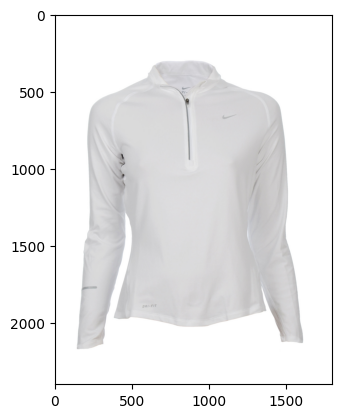

(1440, 1080, 3)


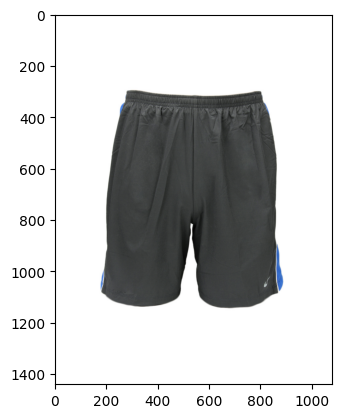

In [9]:
import matplotlib.pyplot as plt

for i in range(10003, 10005):
    # Load the image
    image = plt.imread(f"{IMAGES_PATH}{i}.jpg")
    print(image.shape)
    # Display the image
    plt.imshow(image)
    plt.show()


In [10]:
import tensorflow as tf

def decode_and_resize(image_path, target_height=224, target_width=224):
    """
    Decode a JPEG image from a file path and resize it to target dimensions.
    
    Args:
        image_path (str): Path to the JPEG image file
        target_height (int): Target height for resizing, default 224
        target_width (int): Target width for resizing, default 224
        
    Returns:
        tf.Tensor: Decoded and resized image tensor with shape (target_height, target_width, 3)
                  and values normalized to [0, 1] range
    """
    # Read the file contents
    image_data = tf.io.read_file(image_path)
    
    # Decode the JPEG image
    image = tf.io.decode_jpeg(image_data, channels=3)
    
    # Convert to float32 and normalize to [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    # Resize the image to target dimensions
    resized_image = tf.image.resize(image, [target_height, target_width])
    
    return resized_image


def process_input(img_path, targets):
    
  return decode_and_resize(IMAGES_PATH+img_path), targets

In [11]:
def make_dataset(images, targets):
  dataset = tf.data.Dataset.from_tensor_slices((images, targets))
  dataset = dataset.shuffle(BATCH_SIZE * 2)
  dataset = dataset.map(process_input, num_parallel_calls=AUTOTUNE)
  dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

  return dataset

In [45]:
train_dataset = make_dataset(train_df_encoded.index.tolist(), train_df_encoded.to_dict(orient="list"))
val_dataset = make_dataset(val_df_encoded.index.tolist(), val_df_encoded.to_dict(orient="list"))
test_dataset = make_dataset(test_df_encoded.index.tolist(), test_df_encoded.to_dict(orient="list"))


In [13]:
num_baseColour = train_df_encoded.baseColour.nunique()
num_articleType = train_df_encoded.articleType.nunique()
num_season = train_df_encoded.season.nunique()
num_gender = train_df_encoded.gender.nunique()

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [17]:


# Load Pretrained ResNet50 Model (without top layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

# Define Input
inputs = Input(shape=(224, 224, 3))

# Pass Input Through ResNet50
x = base_model(inputs, training=False)

# Global Average Pooling
x = GlobalAveragePooling2D()(x)

# Fully Connected Layers
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)

# Output Layers for Multi-Label Classification
baseColour_output = Dense(num_baseColour, activation='softmax', name='baseColour')(x)
articleType_output = Dense(num_articleType, activation='softmax', name='articleType')(x)
season_output = Dense(num_season, activation='softmax', name='season')(x)
gender_output = Dense(num_gender, activation='softmax', name='gender')(x)

# Define the Model
model = Model(inputs=inputs, outputs=[articleType_output, baseColour_output, gender_output, season_output])

# Compile the Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss={
        "articleType": "sparse_categorical_crossentropy",
        "baseColour": "sparse_categorical_crossentropy",
        "season": "sparse_categorical_crossentropy",
        "gender": "sparse_categorical_crossentropy"
    },
    metrics={
        "articleType": "accuracy",
        "baseColour": "accuracy",
        "season": "accuracy",
        "gender": "accuracy"
    }
)

# Model Summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 7, 7, 2048)     │     23,587,712 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 2048)           │              0 │ resnet50[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 512)            │      1,049,088 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 512)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 256)            │        131,328 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 256)            │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ articleType (Dense)       │ (None, 26)             │          6,682 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ baseColour (Dense)        │ (None, 10)             │          2,570 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gender (Dense)            │ (None, 3)              │            771 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ season (Dense)            │ (None, 4)              │          1,028 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 24,779,179 (94.53 MB)

 Trainable params: 1,191,467 (4.55 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [18]:

history = model.fit(
        train_dataset,
        batch_size=BATCH_SIZE,
        # validation_data=validation_dataset,
        epochs=9,
        verbose=1,
        # callbacks=[model_ckpt],
        # class_weight=class_weights
    )

Epoch 1/9
562/562 ━━━━━━━━━━━━━━━━━━━━ 619s 1s/step - articleType_accuracy: 0.2838 - articleType_loss: 2.4361 - baseColour_accuracy: 0.2909 - baseColour_loss: 2.0141 - gender_accuracy: 0.5758 - gender_loss: 0.8160 - loss: 6.4089 - season_accuracy: 0.4652 - season_loss: 1.1427
Epoch 2/9
562/562 ━━━━━━━━━━━━━━━━━━━━ 537s 954ms/step - articleType_accuracy: 0.4845 - articleType_loss: 1.5426 - baseColour_accuracy: 0.3387 - baseColour_loss: 1.8521 - gender_accuracy: 0.7345 - gender_loss: 0.6020 - loss: 4.9929 - season_accuracy: 0.5451 - season_loss: 0.9963
Epoch 3/9
562/562 ━━━━━━━━━━━━━━━━━━━━ 532s 947ms/step - articleType_accuracy: 0.5385 - articleType_loss: 1.3528 - baseColour_accuracy: 0.3589 - baseColour_loss: 1.8097 - gender_accuracy: 0.7603 - gender_loss: 0.5528 - loss: 4.6745 - season_accuracy: 0.5655 - season_loss: 0.9592
Epoch 4/9
562/562 ━━━━━━━━━━━━━━━━━━━━ 532s 945ms/step - articleType_accuracy: 0.5704 - articleType_loss: 1.2511 - baseColour_accuracy: 0.3643 - baseColour_loss: 1

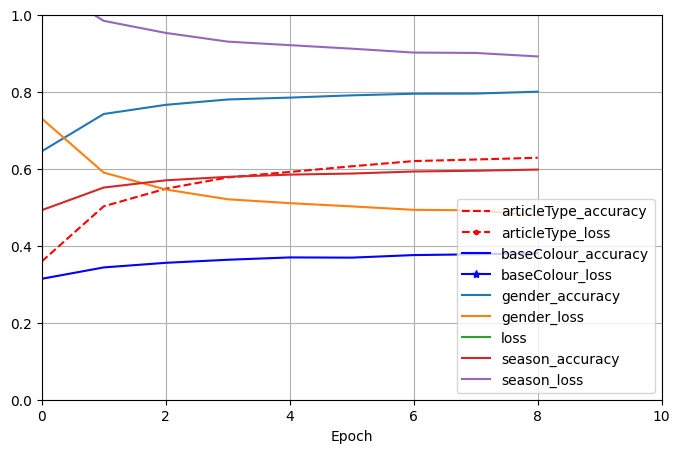

In [46]:
import pandas as pd
pd.DataFrame(history.history).plot(
figsize=(8, 5), xlim=[0, 10], ylim=[0, 5], grid=True, xlabel="Epoch",
style=["r--", "r--.", "b-", "b-*"])
plt.show()

In [23]:
preds_probs = model.predict(tf.constant([decode_and_resize(IMAGES_PATH+"42600.jpg").numpy()]))
preds_probs

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


[array([[1.7614877e-04, 4.1539370e-04, 1.7817409e-03, 6.4932252e-04,
         1.2213016e-04, 3.0173672e-02, 8.5402080e-06, 2.1200761e-04,
         4.4481563e-05, 1.7432636e-04, 3.3305114e-05, 1.8355236e-04,
         1.6468729e-01, 1.9159491e-01, 4.7772963e-04, 8.9349873e-05,
         1.4316821e-01, 6.2876008e-04, 6.3125677e-05, 3.8314654e-05,
         1.0825170e-06, 1.6242266e-01, 4.2127981e-04, 3.0213490e-01,
         5.8924172e-05, 2.3887541e-04]], dtype=float32),
 array([[0.12807661, 0.22775936, 0.04480855, 0.14813831, 0.00097683,
         0.04935042, 0.07846882, 0.12991503, 0.09666685, 0.09583922]],
       dtype=float32),
 array([[0.29404354, 0.00193684, 0.70401967]], dtype=float32),
 array([[0.39254534, 0.0055283 , 0.5780573 , 0.02386913]], dtype=float32)]

In [24]:
preds = [tf.argmax(pred, axis=1) for pred in preds_probs]
preds

[<tf.Tensor: shape=(1,), dtype=int64, numpy=array([23])>,
 <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 <tf.Tensor: shape=(1,), dtype=int64, numpy=array([2])>,
 <tf.Tensor: shape=(1,), dtype=int64, numpy=array([2])>]

In [25]:
model.save("multioutput_model.keras")

In [29]:
ls

multioutput_model.keras


In [30]:
loaded_model = tf.keras.models.load_model(
    "multioutput_model.keras"
)

In [43]:
preds_probs = loaded_model.predict(tf.constant([decode_and_resize(IMAGES_PATH+"10003.jpg").numpy()]))
preds_probs

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


[array([[0.00371198, 0.00473572, 0.05707788, 0.08247179, 0.0070347 ,
         0.01923486, 0.00262375, 0.00981092, 0.00090045, 0.03813283,
         0.00632158, 0.00532974, 0.00442955, 0.3185333 , 0.14341375,
         0.00332642, 0.01468094, 0.03378466, 0.04001988, 0.00413852,
         0.00192294, 0.05582704, 0.00738415, 0.07720789, 0.04794012,
         0.01000469]], dtype=float32),
 array([[0.06662675, 0.10090834, 0.0616557 , 0.05161826, 0.16738506,
         0.05263408, 0.0356432 , 0.092571  , 0.3098709 , 0.06108668]],
       dtype=float32),
 array([[0.3077632 , 0.04219987, 0.65003693]], dtype=float32),
 array([[0.17403066, 0.21761021, 0.45828348, 0.15007567]], dtype=float32)]

In [44]:
preds = [tf.argmax(pred, axis=1) for pred in preds_probs]
out = ["articleType", "baseColour", "gender", "season" ]
for p, o in zip(preds, out):
    
    print(loaded_encoders_dict[o].inverse_transform(p)) 
    print(p[0])

['Other']
tf.Tensor(13, shape=(), dtype=int64)
['White/Cream']
tf.Tensor(8, shape=(), dtype=int64)
['Women']
tf.Tensor(2, shape=(), dtype=int64)
['Summer']
tf.Tensor(2, shape=(), dtype=int64)


In [47]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load Pretrained ResNet50 Model (without top layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

# Define Input
inputs = Input(shape=(224, 224, 3))

# Pass Input Through ResNet50
x = base_model(inputs, training=False)

# Global Average Pooling
x = GlobalAveragePooling2D()(x)

# Fully Connected Layers
x_article_type = Dense(512, activation='relu')(x)
x_article_type = Dropout(0.3)(x_article_type)
x_article_type = Dense(256, activation='relu')(x_article_type)
x_article_type = Dropout(0.3)(x_article_type)

# Fully Connected Layers
x_base_color = Dense(512, activation='relu')(x)
x_base_color = Dropout(0.3)(x_base_color)
x_base_color = Dense(256, activation='relu')(x_base_color)
x_base_color = Dropout(0.3)(x_base_color)

# Fully Connected Layers
x_season = Dense(512, activation='relu')(x)
x_season = Dropout(0.3)(x_season)
x_season = Dense(256, activation='relu')(x_season)
x_season = Dropout(0.3)(x_season)

# Fully Connected Layers
x_gender = Dense(512, activation='relu')(x)
x_gender = Dropout(0.3)(x_gender)
x_gender = Dense(256, activation='relu')(x_gender)
x_gender = Dropout(0.3)(x_gender)

# Output Layers for Multi-Label Classification
baseColour_output = Dense(num_baseColour, activation='softmax', name='baseColour')(x_base_color)
articleType_output = Dense(num_articleType, activation='softmax', name='articleType')(x_article_type)
season_output = Dense(num_season, activation='softmax', name='season')(x_season)
gender_output = Dense(num_gender, activation='softmax', name='gender')(x_gender)

# Define the Model
model = Model(inputs=inputs, outputs=[articleType_output, baseColour_output, gender_output, season_output])

# Compile the Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss={
        "articleType": "sparse_categorical_crossentropy",
        "baseColour": "sparse_categorical_crossentropy",
        "season": "sparse_categorical_crossentropy",
        "gender": "sparse_categorical_crossentropy"
    },
    metrics={
        "articleType": "accuracy",
        "baseColour": "accuracy",
        "season": "accuracy",
        "gender": "accuracy"
    }
)

# Model Summary
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 7, 7, 2048)     │     23,587,712 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 2048)           │              0 │ resnet50[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_20 (Dense)          │ (None, 512)            │      1,049,088 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_22 (Dense)          │ (None, 512)            │      1,049,088 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_26 (Dense)          │ (None, 512)            │      1,049,088 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_24 (Dense)          │ (None, 512)            │      1,049,088 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_20 (Dropout)      │ (None, 512)            │              0 │ dense_20[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_22 (Dropout)      │ (None, 512)            │              0 │ dense_22[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_26 (Dropout)      │ (None, 512)            │              0 │ dense_26[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_24 (Dropout)      │ (None, 512)            │              0 │ dense_24[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_21 (Dense)          │ (None, 256)            │        131,328 │ dropout_20[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_23 (Dense)          │ (None, 256)            │        131,328 │ dropout_22[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_27 (Dense)          │ (None, 256)            │        131,328 │ dropout_26[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_25 (Dense)          │ (None, 256)            │        131,328 │ dropout_24[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_21 (Dropout)      │ (None, 256)            │              0 │ dense_21[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_23 (Dropout)      │ (None, 256)            │              0 │ dense_23[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_27 (Dropout)      │ (None, 256)            │              0 │ dense_27[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_25 (Dropout) 

 Total params: 28,320,427 (108.03 MB)

 Trainable params: 4,732,715 (18.05 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

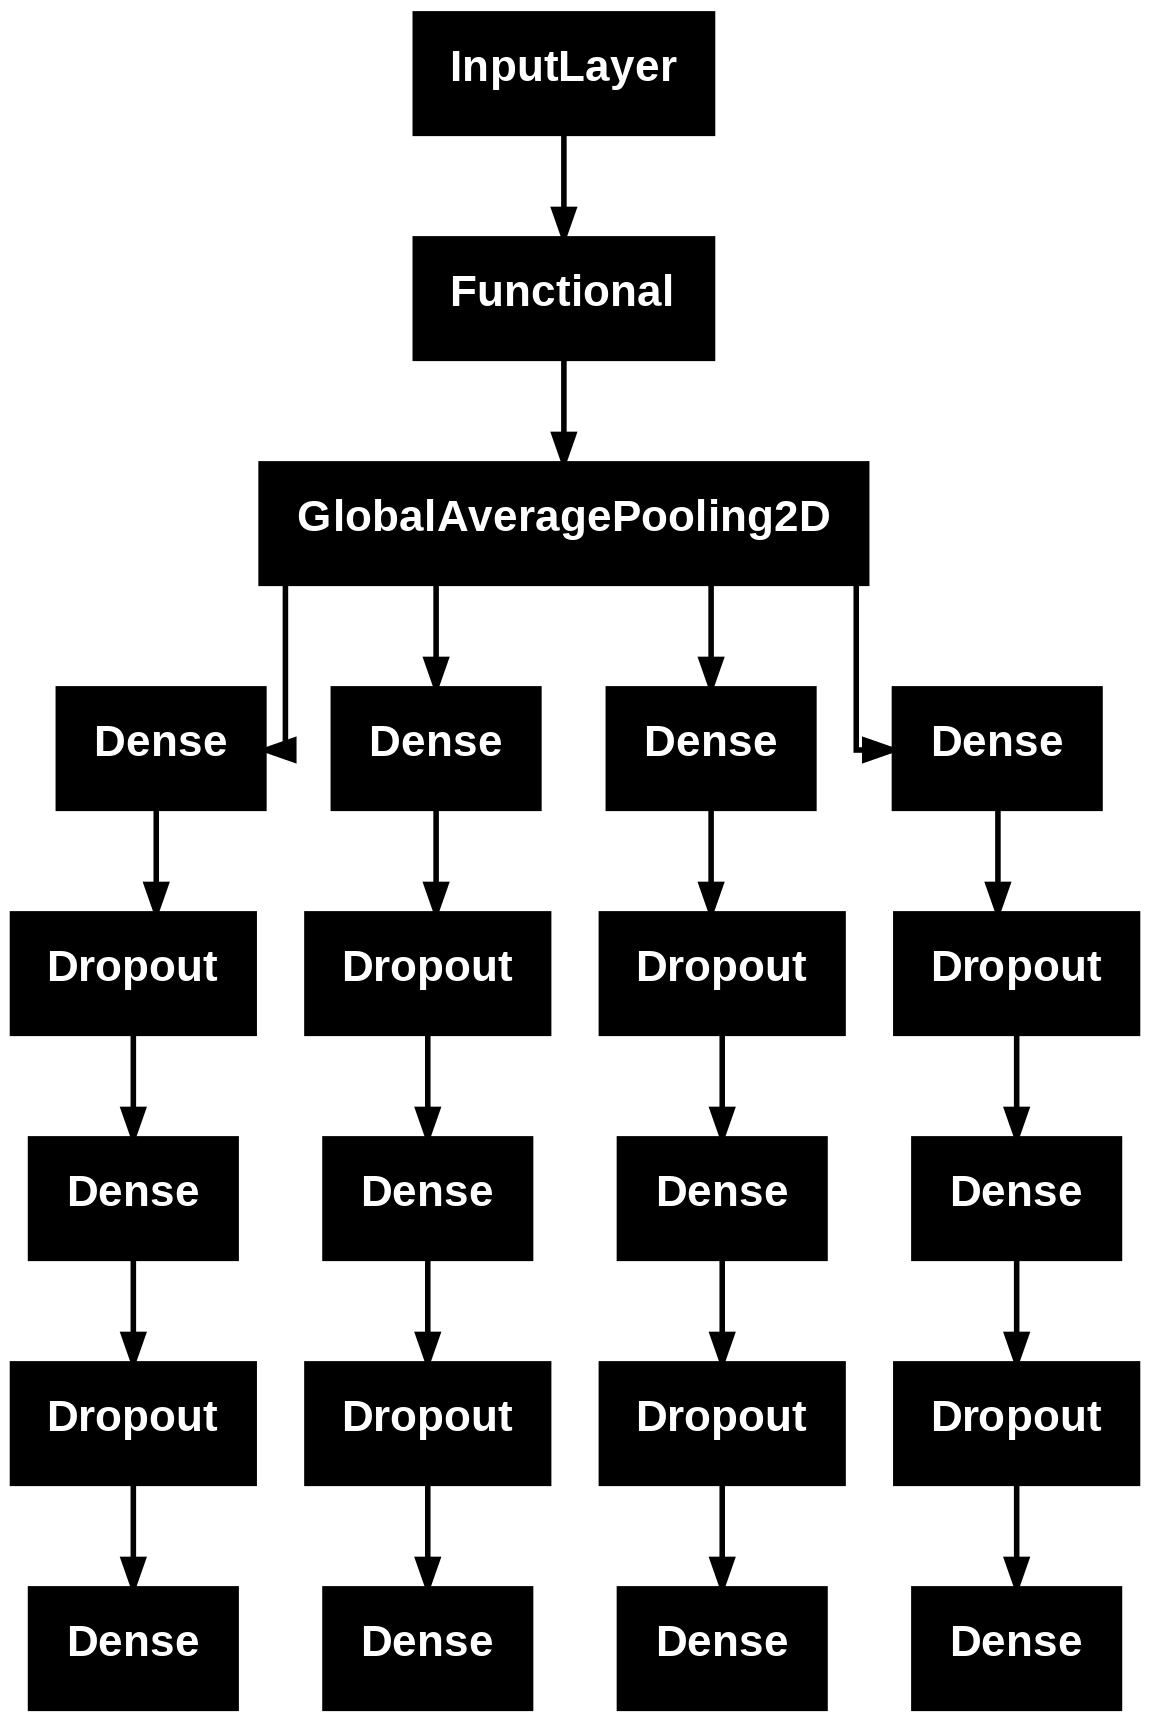

In [48]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [50]:

history = model.fit(
        train_dataset,
        batch_size=BATCH_SIZE,
        validation_data=val_dataset,
        epochs=5,
        verbose=1,
        # callbacks=[model_ckpt],
        # class_weight=class_weights
    )

Epoch 1/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 592s 1s/step - articleType_accuracy: 0.5008 - articleType_loss: 1.4874 - baseColour_accuracy: 0.3433 - baseColour_loss: 1.8656 - gender_accuracy: 0.7434 - gender_loss: 0.5903 - loss: 4.9493 - season_accuracy: 0.5351 - season_loss: 1.0060 - val_articleType_accuracy: 0.6028 - val_articleType_loss: 1.1719 - val_baseColour_accuracy: 0.3544 - val_baseColour_loss: 1.8115 - val_gender_accuracy: 0.7682 - val_gender_loss: 0.5485 - val_loss: 4.4917 - val_season_accuracy: 0.5675 - val_season_loss: 0.9644
Epoch 2/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 588s 1s/step - articleType_accuracy: 0.5597 - articleType_loss: 1.2917 - baseColour_accuracy: 0.3532 - baseColour_loss: 1.8344 - gender_accuracy: 0.7456 - gender_loss: 0.5814 - loss: 4.6926 - season_accuracy: 0.5457 - season_loss: 0.9851 - val_articleType_accuracy: 0.6128 - val_articleType_loss: 1.1014 - val_baseColour_accuracy: 0.3735 - val_baseColour_loss: 1.7699 - val_gender_accuracy: 0.7812 - val_gender_loss: 0.5283

In [51]:
model.save("multioutput_model_resnet_v2.keras")

In [52]:
loaded_model = tf.keras.models.load_model(
    "multioutput_model_resnet_v2.keras"
)

In [78]:
test_targets.columns

Index(['baseColour', 'articleType', 'season', 'gender'], dtype='object')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


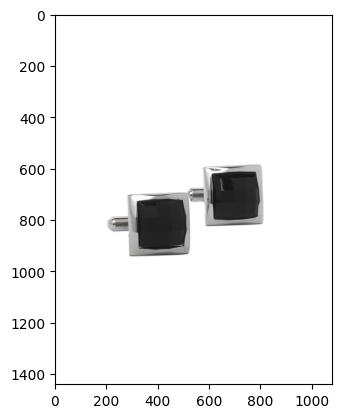

Predictions articleType:  ['Other'] ,Actual articleType:  ['Other'] , 
Predictions baseColour:  ['Black/Grey'] ,Actual baseColour:  ['Black/Grey'] , 
Predictions gender:  ['Men'] ,Actual gender:  ['Men'] , 
Predictions season:  ['Summer'] ,Actual season:  ['Summer'] , 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


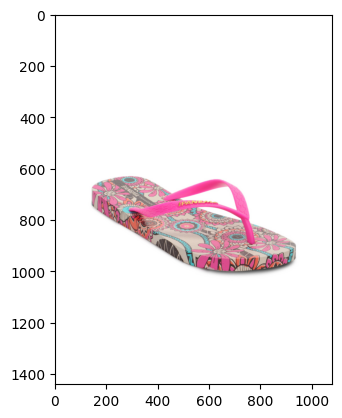

Predictions articleType:  ['Heels'] ,Actual articleType:  ['Flip Flops'] , 
Predictions baseColour:  ['White/Cream'] ,Actual baseColour:  ['Red/Pink'] , 
Predictions gender:  ['Women'] ,Actual gender:  ['Women'] , 
Predictions season:  ['Summer'] ,Actual season:  ['Winter'] , 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


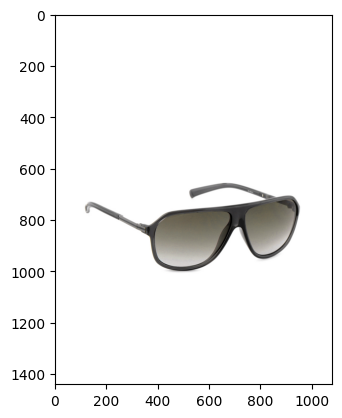

Predictions articleType:  ['Sunglasses'] ,Actual articleType:  ['Sunglasses'] , 
Predictions baseColour:  ['Black/Grey'] ,Actual baseColour:  ['Black/Grey'] , 
Predictions gender:  ['Men'] ,Actual gender:  ['Men'] , 
Predictions season:  ['Winter'] ,Actual season:  ['Winter'] , 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


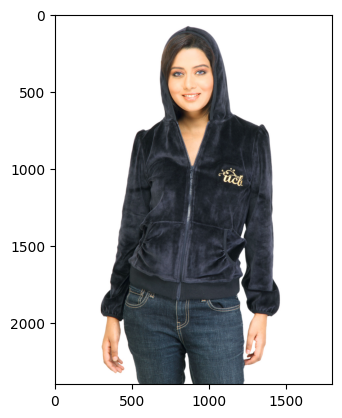

Predictions articleType:  ['Tops'] ,Actual articleType:  ['Other'] , 
Predictions baseColour:  ['Blue'] ,Actual baseColour:  ['Black/Grey'] , 
Predictions gender:  ['Men'] ,Actual gender:  ['Women'] , 
Predictions season:  ['Summer'] ,Actual season:  ['Fall'] , 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


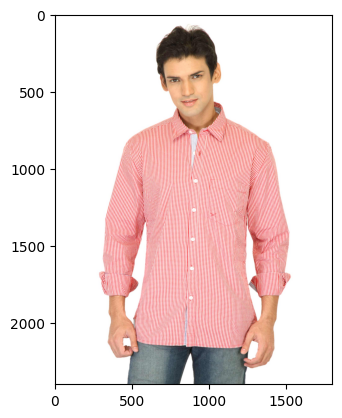

Predictions articleType:  ['Shirts'] ,Actual articleType:  ['Shirts'] , 
Predictions baseColour:  ['Blue'] ,Actual baseColour:  ['Red/Pink'] , 
Predictions gender:  ['Men'] ,Actual gender:  ['Men'] , 
Predictions season:  ['Summer'] ,Actual season:  ['Fall'] , 


In [87]:
test_images_path = test_df_encoded[out].sample(5).index.values
test_targets = test_df_encoded[out].loc[test_images_path].copy()

for image_path, target in zip(test_images_path, test_targets.to_numpy()):

    preds_probs = loaded_model.predict(tf.constant([decode_and_resize(IMAGES_PATH+image_path).numpy()]))
    preds = [tf.argmax(pred, axis=1) for pred in preds_probs]
    image = plt.imread(f"{IMAGES_PATH}{image_path}")
    plt.imshow(image)
    plt.show()
    
    out = ["articleType", "baseColour", "gender", "season"]
    for p, o, t in zip(preds, out, target):
        # print(t)
        # print(p)
        print(f"Predictions {o}: ",loaded_encoders_dict[o].inverse_transform(p), end=" ,") 
        print(f"Actual {o}: ",loaded_encoders_dict[o].inverse_transform([t]), end=" ,")
        print(" ")
        


### Over fit to blur color 
### Bit of bias toward MEN 
